In [1]:
from Bio import SeqIO, Align
from os import listdir

import pandas as pd
import re
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import gzip

In [2]:
spacer_file = pd.read_excel('./spacers_subset.xlsx')
spacer_file['Spacer'] = spacer_file['Spacer'].apply(str.upper)

rna_sort_file = pd.read_excel('./mRNA_list.xlsx', header=None)
rna_sort_list = list(rna_sort_file[0])

name_dict = dict(zip(spacer_file['Spacer'], spacer_file['Name']))

fq_files = [name for name in listdir('./fastq3/') if name.endswith('fastq.gz')]

In [4]:
# rna_sort_list.index('A')

In [3]:
report_mat = pd.DataFrame(columns=list(spacer_file['Name']) + ['read error', 'missing in read', 'unknown spacer'], index=[name[0:-9] for name in fq_files])
report_mat.fillna(0, inplace=True)

In [4]:
report_mat

,Impa1_gRNA1,Impa1_gRNA2,Impa1_gRNA3,Impa1_gRNA4,Impa1_gRNA5,Kpnb1_gRNA1,Kpnb1_gRNA2,Kpnb1_gRNA3,Kpnb1_gRNA4,Kpnb1_gRNA5,...,Rptor_gRNA4,Rptor_gRNA5,Alkbh5_gRNA1,Alkbh5_gRNA2,Alkbh5_gRNA3,Alkbh5_gRNA4,Alkbh5_gRNA5,read error,missing in read,unknown spacer
Akt3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alkbh5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Camk2a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dixdc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Eif4b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fmr1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gsk3b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Impa1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kpnb1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
L1cam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
len(name_dict.keys())

105

In [5]:
def spacer_aligner(spacer, threshold=28):
    aligner = Align.PairwiseAligner()
    aligner.mode = 'global'
    
    spacer_refs = list(name_dict.keys())
    for idx, spacer_ref in enumerate(spacer_refs):
        aln_score = aligner.score(spacer_ref, spacer)

        if aln_score > threshold:
            return spacer_ref
            
    return None

In [6]:
spacer_re = re.compile(r'ACACC((A|C|T|G){28,32})GTTGT')

In [7]:
unknownList = []
for file in fq_files:
    print('Processing {0}'.format(file))
    unknownList.append([])
    with gzip.open('./fastq3/' + file, 'rt') as fastqFile:
        records = SeqIO.parse(fastqFile, 'fastq')
        
        mat_idx = file[0:-9]
        for record in records:
            if len(record.seq) < 2800 or len(record.seq) > 3100:
                mat_col = 'read error'
    
            else:
                sp_match_f = spacer_re.search(str(record.seq))
                if sp_match_f is None:
                    sp_match_r = spacer_re.search(str(record.seq.reverse_complement()))
                    if not (sp_match_r is None):
                        spacer = sp_match_r.group(1)
                    else:
                        spacer = None
                else:
                    spacer = sp_match_f.group(1)
        
                if spacer is None:
                    mat_col = 'missing in read'
                elif spacer in name_dict:
                    mat_col = name_dict[spacer]
                else:
                    aln_spacer = spacer_aligner(spacer, threshold=27)
                    if aln_spacer is None:
                        unknownList[-1].append(spacer)
                        mat_col = 'unknown spacer'
                    else:
                        mat_col = name_dict[aln_spacer]
    
            report_mat.loc[mat_idx, mat_col] += 1

report_mat_frac = report_mat.div(report_mat.sum(axis=1), axis=0)

Processing Akt3.fastq.gz
Processing Alkbh5.fastq.gz
Processing Camk2a.fastq.gz
Processing Dixdc1.fastq.gz
Processing Eif4b.fastq.gz
Processing Fmr1.fastq.gz
Processing Gsk3b.fastq.gz
Processing Impa1.fastq.gz
Processing Kpnb1.fastq.gz
Processing L1cam.fastq.gz
Processing Map1b.fastq.gz
Processing mTOR.fastq.gz
Processing Pten.fastq.gz
Processing Pum2.fastq.gz
Processing RhoA.fastq.gz
Processing Rictor.fastq.gz
Processing Rptor.fastq.gz
Processing Smn1.fastq.gz
Processing Stmn2.fastq.gz
Processing TDP43.fastq.gz
Processing Tmsb4x.fastq.gz


In [8]:
report_mat

,Impa1_gRNA1,Impa1_gRNA2,Impa1_gRNA3,Impa1_gRNA4,Impa1_gRNA5,Kpnb1_gRNA1,Kpnb1_gRNA2,Kpnb1_gRNA3,Kpnb1_gRNA4,Kpnb1_gRNA5,...,Rptor_gRNA4,Rptor_gRNA5,Alkbh5_gRNA1,Alkbh5_gRNA2,Alkbh5_gRNA3,Alkbh5_gRNA4,Alkbh5_gRNA5,read error,missing in read,unknown spacer
Akt3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,89,511,115
Alkbh5,0,0,0,0,0,0,0,0,0,0,...,0,0,390,435,354,440,503,82,567,122
Camk2a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,72,396,89
Dixdc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,87,547,173
Eif4b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,100,485,142
Fmr1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,78,569,98
Gsk3b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,135,386,91
Impa1,425,510,446,477,481,0,0,0,0,0,...,0,0,0,0,0,0,0,123,341,96
Kpnb1,0,0,0,0,0,486,457,439,365,468,...,0,0,0,0,0,0,0,69,520,101
L1cam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,89,537,115


In [68]:
spacer20mer = [seq for seq in unknownList[4] if len(seq) == 30]
for spacer in spacer20mer:
    print(spacer)

GGACTTCATCTCAAAAGACATCTCCCAAGT
GTCACATACGTTGTGAACAAGCACCAGCGT
GCGACCAGCCAATCAAATCCACCGGAGAAA
GGCAGAAATCAAAGATGGCGCGGAGAAAAC
GGCAGAAATCGAAGGAGTGGCAGGAGAAAC
GGATTTTACGTCTGAGAACATCTCCCAAGT
GTATTTTACATCTCAAAACATTTCCCAAGT
CGCCAACACCCGCTGACGCGCCCTGACGGG
GCTACTAGCCAATCAATGATCCTGCAGAAG
GTCACATACGTTGTCAACAAGCACCAGCGT
ACTGCTCGCGAATCAAATCCACCGGAGAAG
GGATTTTTAGTCTCAGAGCATCTCCCAAGT
GGCAGAAATCAAAGATGGCGCGGAGAAAAC
ACTACTCACCAATCAGATCCACCGGAGAAG
GGCAGAAATTAAAGATGGCGCAGAGAAAAC
GGCAGATCAAAGATCAGCGCCAGAGAAAAC
CGCCAACACCCGCTGACGCGCCCTGACGGG
GCTGCTCGCCAATCAGATCCACCGGAGAAG
GCCATTAAAAGAATACAGGTCAAGCTACAG
GCTACTAGCCAATGGGATACCACGGAGAAG
GCTACTAGCCAATGATATCTACTGGAGAAG
AGATTTACATTGTTCGACATTCTCCCAAGT
GGATTTTAGTCTTCAAGACATCTGCCAAGT
GCACATCAAGACAGACAGGTGAGACTACAG
GGAGGATCACATCTCAAAACATTCCCAAGT
GGCAGAAATCAAAAATAGCGCCGAGAAAAC
CAGGTTTACACTTTATGCTTCCGGCTCTAT
GATTACTGCATCTCAAGACATCTCCCAAGT
GGATTTTAGTCTACCAAGACATCTCCAAGT
ACTTCTGCGCAATTAAATCCACCGGAGAAG
GCACGTGAAGAACAACAGGTCAAGCTACAG
GCACATCAAAGCAGACGGGTAAAGTTACAG
GTCACATA

In [69]:
len(unknownList[4])

142

In [70]:
rna_sort_list

['Impa1',
 'Kpnb1',
 'mTOR',
 'TDP43',
 'Stmn2',
 'RhoA',
 'Pum2',
 'Pten',
 'Tmsb4x',
 'Smn1',
 'Map1b',
 'L1cam',
 'Gsk3b',
 'FMRP',
 'Eif4b',
 'Ccd1',
 'Akt4',
 'Rictor',
 'Camk2a',
 'Rptor',
 'Alkbh5']

In [71]:
rna_sort_list.index('Akt4')

16

In [10]:
report_mat_frac = report_mat_frac.sort_index(key=lambda names: [rna_sort_list.index(name) for name in names])
# report_mat_frac = report_mat_frac.reindex(sorted(report_mat_frac.columns, key=str.upper), axis=1)


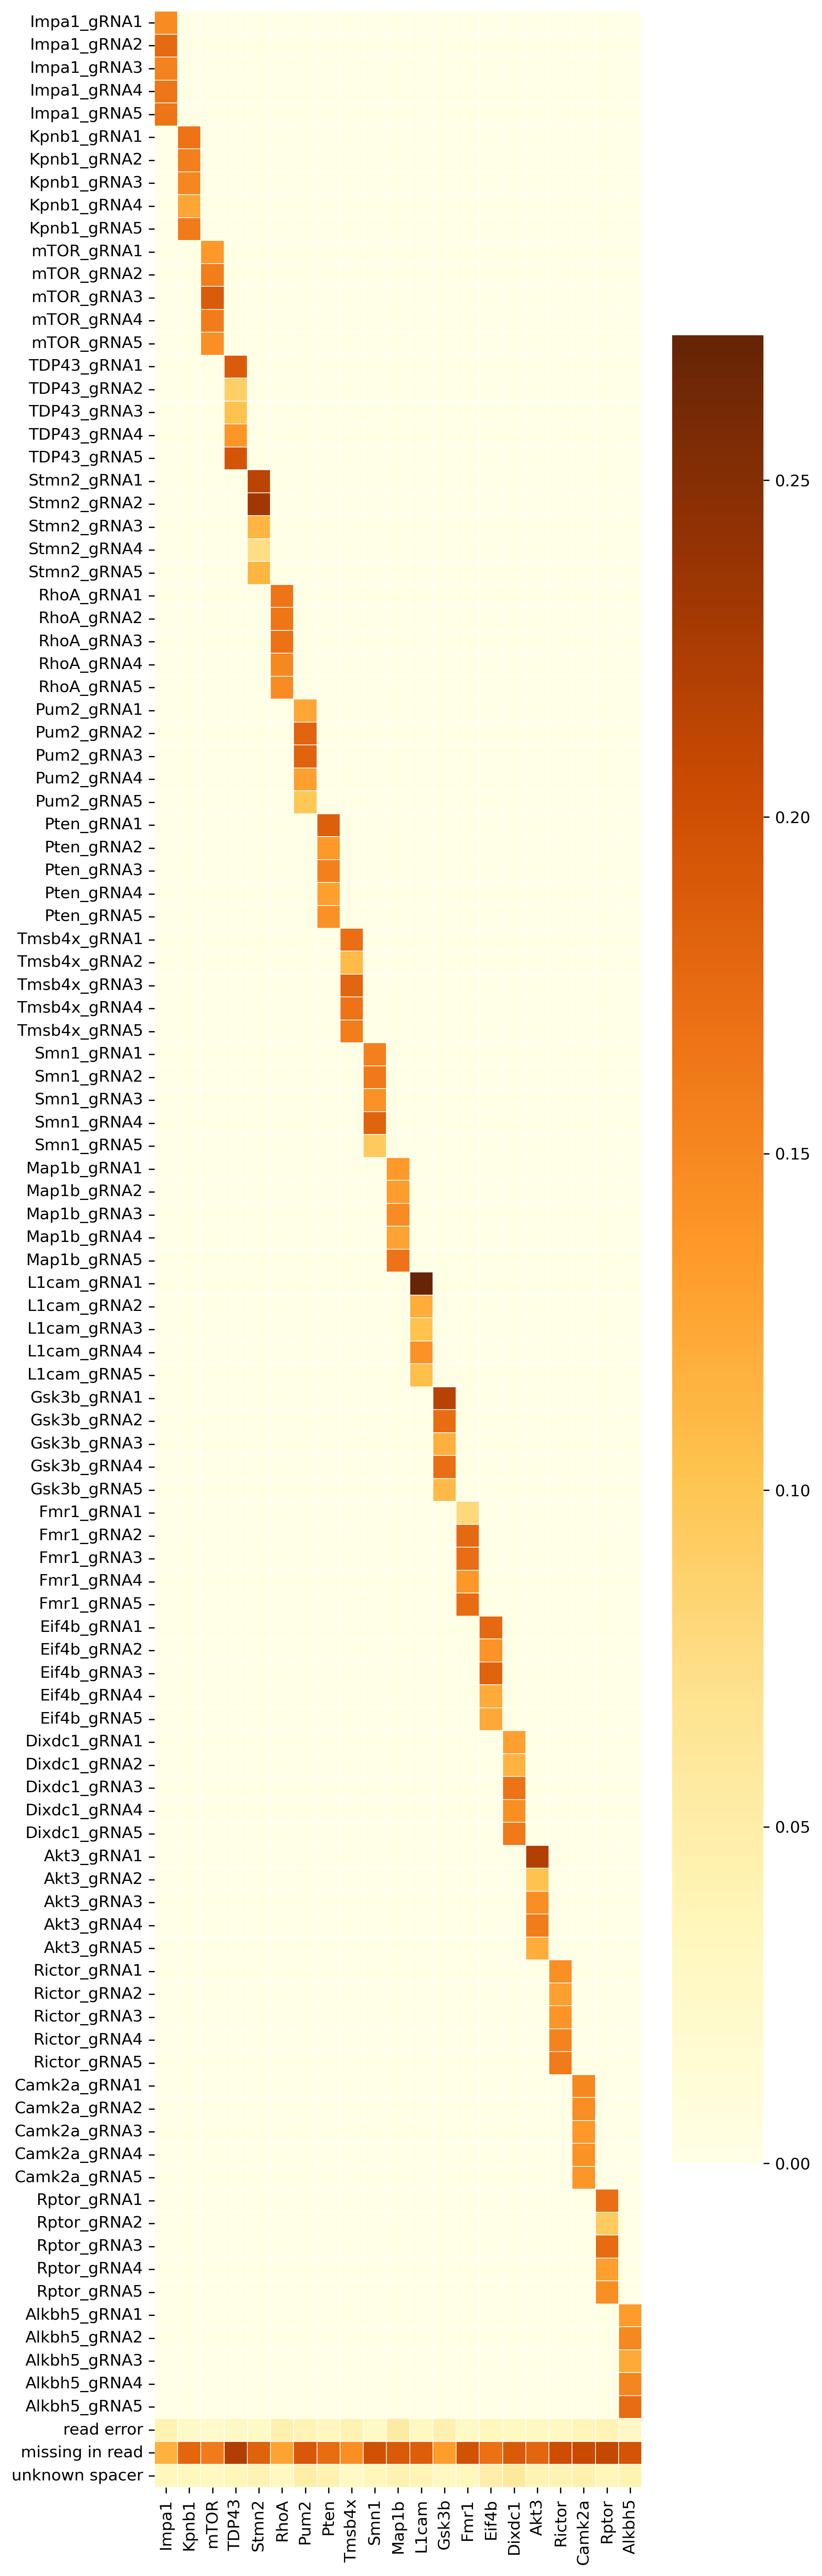

In [18]:
fig, ax = plt.subplots(figsize=(6, 22))
fig.dpi = 300
fig.tight_layout()
sns.heatmap(report_mat_frac.T, xticklabels=True, yticklabels=True, cmap='YlOrBr', ax=ax, linewidths=0.1)

fig.savefig('./report.png', bbox_inches="tight")
fig.savefig('./report.pdf', bbox_inches="tight")

In [33]:
report_mat_frac.to_excel('./report.xlsx')

In [12]:
report_mat_frac

,Impa1_gRNA1,Impa1_gRNA2,Impa1_gRNA3,Impa1_gRNA4,Impa1_gRNA5,Kpnb1_gRNA1,Kpnb1_gRNA2,Kpnb1_gRNA3,Kpnb1_gRNA4,Kpnb1_gRNA5,...,Rptor_gRNA4,Rptor_gRNA5,Alkbh5_gRNA1,Alkbh5_gRNA2,Alkbh5_gRNA3,Alkbh5_gRNA4,Alkbh5_gRNA5,read error,missing,unknown
Akt3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.031294,0.179677,0.040436
Alkb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.134715,0.150259,0.12228,0.151986,0.173748,0.028325,0.195855,0.042142
Camk,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.037539,0.206465,0.046403
Dixd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.030166,0.189667,0.059986
Eif4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.034953,0.169521,0.049633
Fmr1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.027187,0.198327,0.034158
Gsk3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.046472,0.132874,0.031325
Impa,0.146602,0.175923,0.153846,0.164539,0.165919,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.042428,0.117627,0.033115
Kpnb,0.000000,0.000000,0.000000,0.000000,0.000000,0.167298,0.157315,0.151119,0.125645,0.161102,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.023752,0.179002,0.034768
L1ca,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.030828,0.186006,0.039834


In [50]:
aa = spacer_re.search('GAAACACCGAAAGAAGTAAGTAGTGTACTCTGCTGTCAGTTGTGG')
aa.group(1)

'GAAAGAAGTAAGTAGTGTACTCTGCTGTCA'

In [43]:
test_re = re.compile(r'GAAACACC(A|T|C|G){29,31}GTTGTGG')
test_re.search('GGAGAAACACCAAAGAGAAGTAAGTAGTGTACTCTGCTGTCAGTTGTGGTTA')

<re.Match object; span=(3, 49), match='GAAACACCAAAGAGAAGTAAGTAGTGTACTCTGCTGTCAGTTGTGG'>

In [51]:
fq_files

['A_01.fastq',
 'B_02.fastq',
 'C_03.fastq',
 'D_04.fastq',
 'E_05.fastq',
 'F_06.fastq',
 'G_07.fastq',
 'H_08.fastq',
 'I_09.fastq',
 'J_10.fastq',
 'K_11.fastq',
 'L_12.fastq',
 'M_13.fastq',
 'N_14.fastq',
 'O_15.fastq',
 'P_16.fastq',
 'Q_17.fastq',
 'R_18.fastq',
 'S_19.fastq',
 'T_20.fastq',
 'U_21.fastq',
 'V_22.fastq',
 'W_23.fastq',
 'X_24.fastq',
 'Y_25.fastq',
 'Z_26.fastq']